In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

    # Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

In [2]:
if not in_notebook:
    argparser = argparse.ArgumentParser()
    argparser.add_argument(
        "--patient",
        type=str,
        required=True,
        help="Patient ID to process, e.g. 'P01'",
    )
    args = argparser.parse_args()
    patient = args.patient
else:
    patient = "NF0014"

In [3]:
stats_path = pathlib.Path(
    f"{root_dir}/data/{patient}/extracted_features/run_stats/"
).resolve(strict=True)
output_path = pathlib.Path(f"{root_dir}/data/{patient}/converted_profiles/").resolve()
output_path.mkdir(parents=True, exist_ok=True)
stats_output_path = pathlib.Path(
    f"{root_dir}/data/{patient}/profiling_stats/"
).resolve()
stats_output_path.mkdir(parents=True, exist_ok=True)

stats_files = list(stats_path.glob("*.parquet"))
stats_files.sort()

In [4]:
df = pd.concat(
    [pd.read_parquet(stats_file) for stats_file in stats_files],
    ignore_index=True,
)

df.to_parquet(f"{stats_output_path}/{patient}_cell_stats.parquet", index=False)
df["feature_type_and_gpu"] = (
    df["feature_type"].astype(str) + "_" + df["gpu"].astype(str)
)
df["feature_type_and_gpu"] = df["feature_type_and_gpu"].str.replace("None", "CPU")
df["feature_type_and_gpu"] = df["feature_type_and_gpu"].str.replace("True", "GPU")
df["time_taken_minutes"] = df["time_taken"] / 60
df["mem_usage_GB"] = df["mem_usage"] / (1024)
df.head()

,start_time,end_time,start_mem,end_mem,time_taken,mem_usage,gpu,well_fov,patient_id,feature_type,channel,compartment,feature_type_and_gpu,time_taken_minutes,mem_usage_GB
0,1.752011e+09,1.752011e+09,158.464844,1260.312500,19.313591,1101.847656,CPU,C4-2,NF0014,AreaSizeShape,DNA,Nuclei,AreaSizeShape_CPU,0.321893,1.076023
1,1.752011e+09,1.752011e+09,161.437500,1693.878906,14.422077,1532.441406,GPU,C4-2,NF0014,AreaSizeShape,DNA,Nuclei,AreaSizeShape_GPU,0.240368,1.496525
2,1.752011e+09,1.752011e+09,1212.734375,1638.402344,31.019989,425.667969,CPU,C4-2,NF0014,Colocalization,DNA.AGP,Nuclei,Colocalization_CPU,0.517000,0.415691
3,1.752011e+09,1.752011e+09,1210.437500,2261.968750,39.176631,1051.531250,GPU,C4-2,NF0014,Colocalization,DNA.AGP,Nuclei,Colocalization_GPU,0.652944,1.026886
4,1.752015e+09,1.752016e+09,159.746094,1290.300781,1067.435729,1130.554688,CPU,C4-2,NF0014,Granularity,DNA,Nuclei,Granularity_CPU,17.790595,1.104057


## Preliminary plots - will finalize in R later

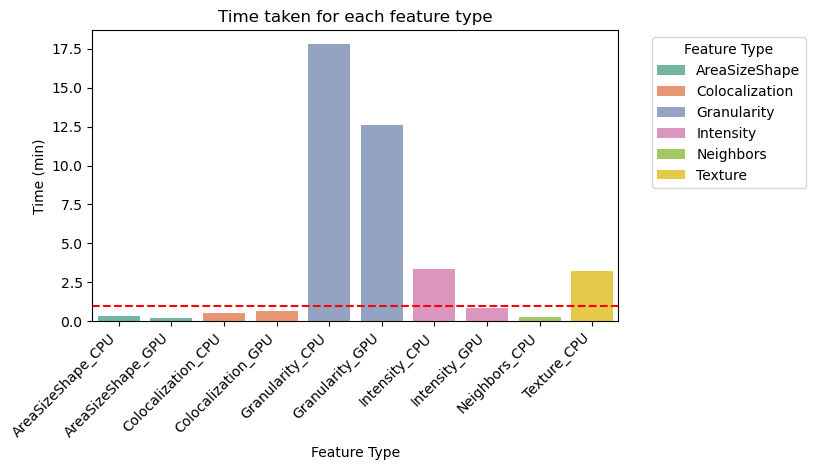

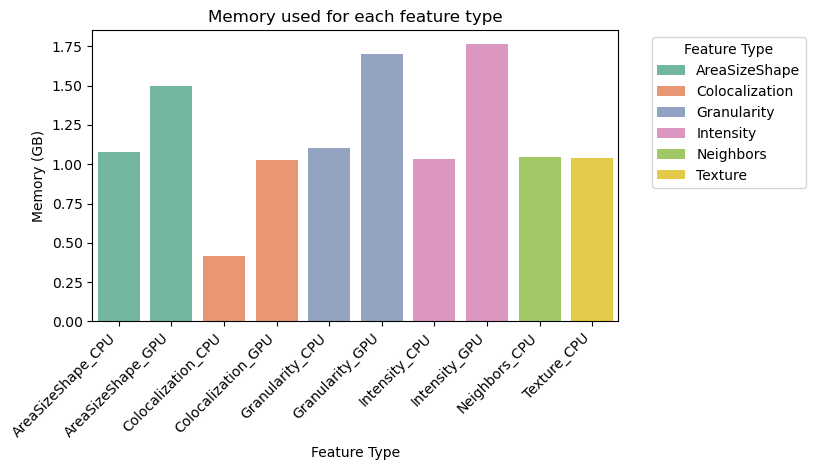

In [5]:
# plot the memory and time for each feature type
if in_notebook:
    sns.barplot(
        data=df,
        x="feature_type_and_gpu",
        y="time_taken_minutes",
        hue="feature_type",
        palette="Set2",
    )
    plt.title("Time taken for each feature type")
    plt.xlabel("Feature Type")
    plt.ylabel("Time (min)")
    plt.xticks(rotation=45, ha="right")
    # horizontal line at 1 minute
    plt.axhline(y=1, color="r", linestyle="--")
    plt.tight_layout()
    # move the legend outside the plot
    plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    sns.barplot(
        data=df,
        x="feature_type_and_gpu",
        y="mem_usage_GB",
        hue="feature_type",
        palette="Set2",
    )

    plt.title("Memory used for each feature type")
    plt.xlabel("Feature Type")
    plt.ylabel("Memory (GB)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show()